In [1]:
%load_ext autoreload
%autoreload 2

# Basic setup

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

# from matplotlib import font_manager, rcParams
# custom_rc = {
#     'font.family': 'DejaVu Sans',
# }

# mpl.rcParams['svg.fonttype'] = 'none'
# mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "gut_dev_Huycke"
file_name = "gut_dev_Huycke_Jul17-1902"
file_suffix = time.strftime('%b%d-%H%M')

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

seed = 0
ccd.ul.set_seed(seed)

In [4]:
# load the data
adata = sc.read_h5ad(data_dir / f"{file_name}_final.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 65468 × 18701
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.5', 'seurat_clusters', 'PercentMito', 'RNA_snn_res.1', 'LaneID', 'MULTI', 'SinDubNeg', 'Age', 'Mouse', 'SegPos', 'RNA_snn_res.5', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'Age_Mouse', 'Age_Pos', 'CellType_Coarse', 'SCT_snn_res.0.8', 'Classification', 'MouseAge', 'SegmentPos', 'MouseAge_combined', 'batch', 'mes_subtype', 'cell_type', 'epi_subtype', 'mes_BN', 'tcf_signaling_response_wnt_score', 'epi_wnt_group', 'MitoFraction', 'seg_classify', 'S_score', 'G2M_score', 'phase', 'broad_cell_type', 'stage', 'leiden_global_Concord', 'mac_subtype'
    var: 'gene_short_name'
    uns: 'LaneID_colors', 'MouseAge_combined_colors', 'batch_colors', 'broad_cell_type_colors', 'cell_type_colors', 'epi_subtype_colors', 'leiden_global_Concord', 'leiden_global_Concord_colors', 'log1p', 'mes_subtype_colors', 'neighbors', 'phase_colors', 'seg_classify_colors', 'stage_colors'
    obsm: 

In [6]:
# Define color palette for broad_cell_type
_, _, celltype_pal = ccd.pl.get_color_mapping(adata, 'cell_type', pal='Set1', seed=seed)
_, _, broad_celltype_pal = ccd.pl.get_color_mapping(adata, 'broad_cell_type', pal='Set1', seed=seed)
_, _, phase_pal = ccd.pl.get_color_mapping(adata, 'phase', pal='Set1', seed=seed)

pal = {"cell_type": celltype_pal,
    "broad_cell_type": broad_celltype_pal,
    'phase': phase_pal,}

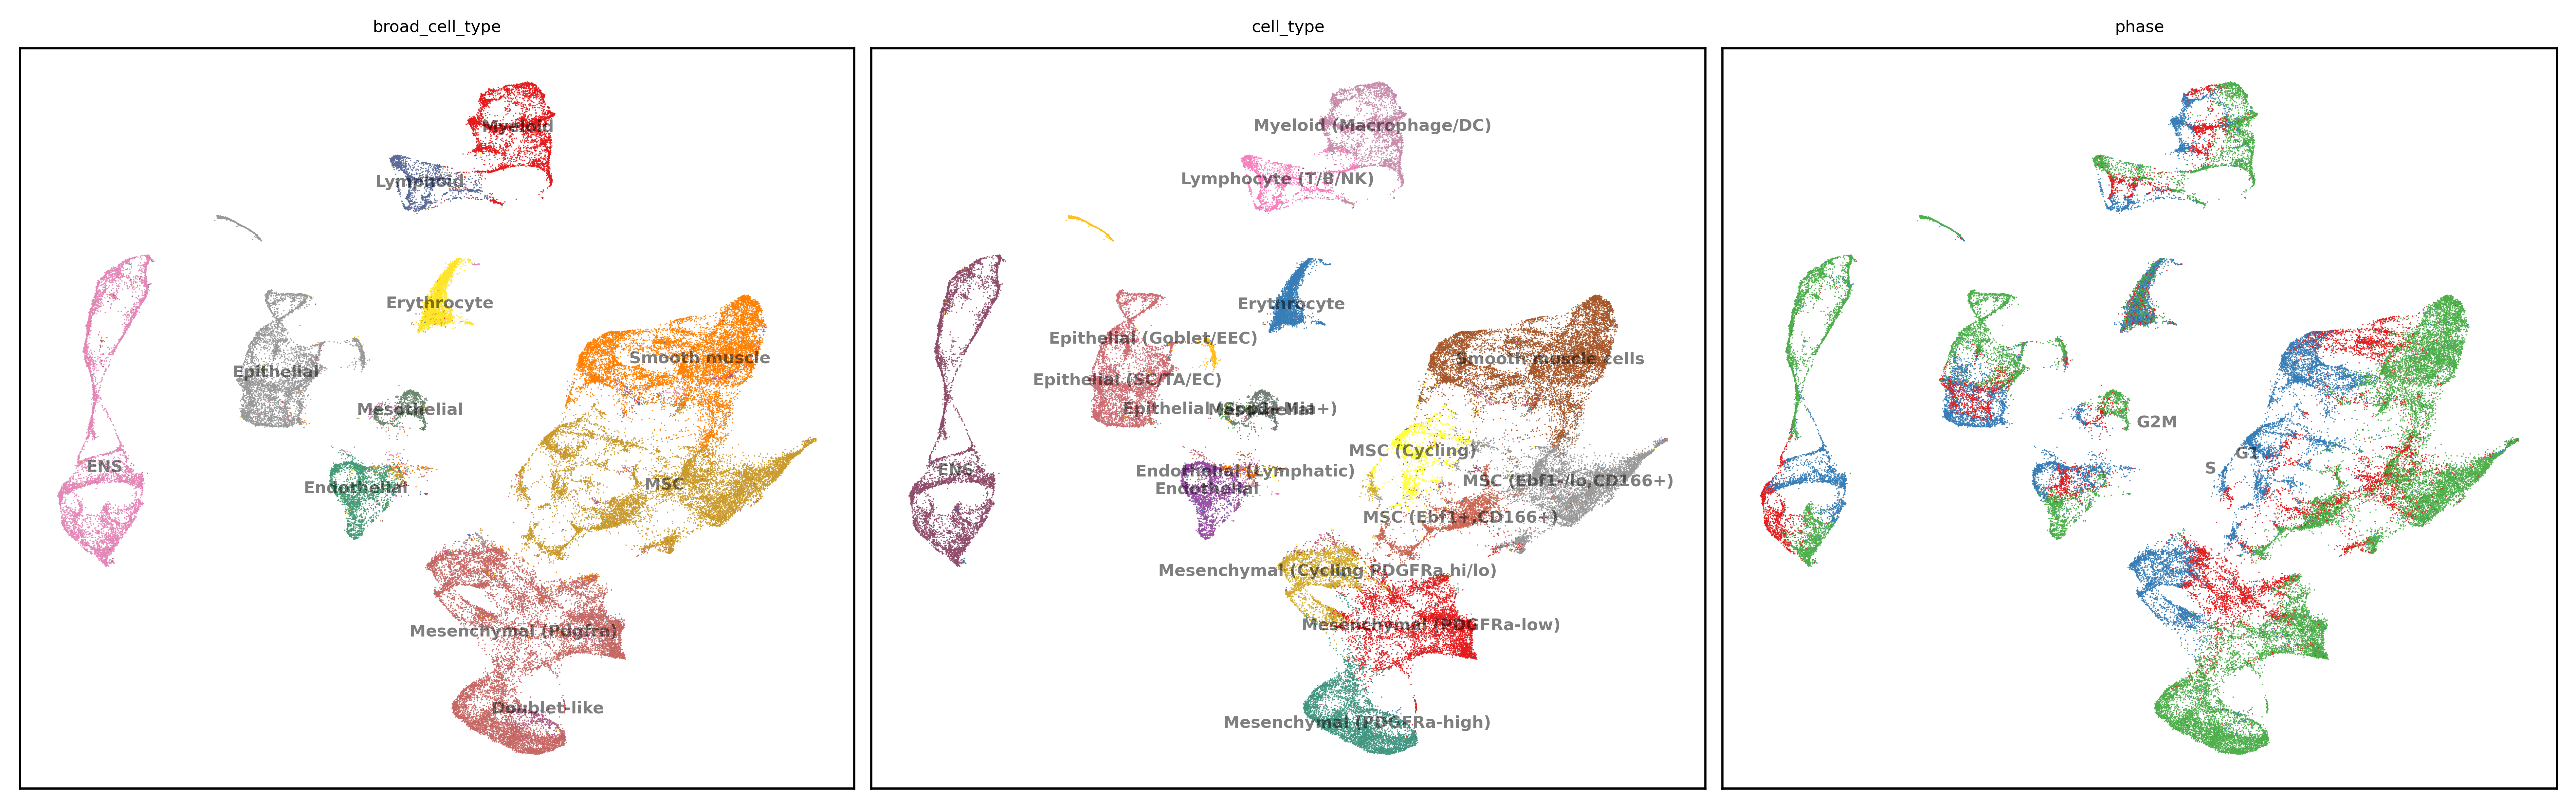

In [7]:
basis = 'concord_hcl'
#basis = 'concord_knn'
show_basis = basis + '_UMAP'
show_cols = ['broad_cell_type', 'cell_type', 'phase']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,4), dpi=600, ncols=3, font_size=6, point_size=1, legend_loc="on data",
    pal=pal,
    save_path=None,
)

In [8]:
# s_genes = [
#     'MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7',
#     'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN',
#     'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45',
#     'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B',
#     'BRIP1', 'E2F8'
# ]
# g2m_genes = [
#     'HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2',
#     'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2',
#     'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1',
#     'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2',
#     'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3',
#     'GAS2L3', 'CBX5', 'CENPA'
# ]

# s_genes = ccd.ul.get_mouse_genes(s_genes)
# g2m_genes = ccd.ul.get_mouse_genes(g2m_genes)

s_genes = [
    'Rad51', 'Cdc45', 'Pcna', 'Mcm5', 'Clspn', 'Chaf1b', 'Ubr7', 'Wdr76', 'Usp1', 'Tyms', 'Atad2', 
    'Casp8ap2', 'Pola1', 'Slbp', 'Dtl', 'Fen1', 'Ccne2', 'Blm', 'Gmnn', 'Rfc2', 'Rrm1', 'Tipin', 
    'Rpa2', 'Hells', 'Brip1', 'Mcm4', 'Rrm2', 'Nasp', 'Uhrf1', 'Dscc1', 'Exo1', 'Rad51ap1', 'Gins2', 
    'Ung', 'Prim1', 'Cdca7', 'E2f8', 'Mcm2', 'Cdc6', 'Mcm6', 'Msh2'
]

g2m_genes = [
    'Gtse1', 'Ccnb2', 'Ckap2', 'Tpx2', 'Ttk', 'Ndc80', 'Aurka', 'Gas2l3', 'Tubb4b', 'Aurkb', 'Kif11', 
    'Hmgb2', 'Nuf2', 'G2e3', 'Nek2', 'Rangap1', 'Kif23', 'Nusap1', 'Dlgap5', 'Hjurp', 'Birc5', 'Cdc25c', 
    'Kif2c', 'Tacc3', 'Ect2', 'Cenpe', 'Cbx5', 'Cdk1', 'Ncapd2', 'Cks2', 'Hmmr', 'Cdca3', 'Ctcf', 
    'Bub1', 'Mki67', 'Cdca2', 'Cdc20', 'Lbr', 'Kif20b', 'Cks1brt', 'Anln', 'Tmpo', 'Ckap5', 'Ckap2l', 
    'Psrc1', 'Smc4', 'Top2a', 'Anp32e', 'Cenpa', 'Cenpf', 'Cdca8'
]

cell_cycle_genes = s_genes + g2m_genes

In [9]:
genes_present = [g for g in cell_cycle_genes if g in adata.var_names]
print(f"{len(genes_present)} genes found in adata.")

92 genes found in adata.


In [39]:
# subset the ENS population
adata_ens = adata[adata.obs['broad_cell_type'] == 'ENS'].copy()

In [ ]:
adata_ens

In [47]:
# Define desired order
phase_order = ["G1", "S", "G2M"]

# Filter and sort cells accordingly
adata_sorted = adata_ens[adata_ens.obs['phase'].isin(phase_order)].copy()
adata_sorted.obs['phase'] = pd.Categorical(adata_sorted.obs['phase'], categories=phase_order, ordered=True)
adata_sorted.obs.sort_values("phase", inplace=True)

# Extract expression matrix for selected genes
expr = adata_sorted[:, genes_present].X
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

print(expr.shape), 
print(adata_sorted.shape)

heatmap_df = pd.DataFrame(expr, index=adata_sorted.obs_names, columns=genes_present)

# Z-score per gene
from scipy.stats import zscore
heatmap_df_z = heatmap_df.apply(zscore, axis=0)
print(heatmap_df_z.shape)


(7404, 92)
(7404, 18701)
(7404, 92)


In [51]:
s_genes_ordered = [g for g in s_genes if g in adata.var_names]
g2m_genes_ordered = [g for g in g2m_genes if g in adata.var_names]
gene_order = s_genes_ordered + g2m_genes_ordered

heatmap_df_z = heatmap_df_z[gene_order]

# Create column colors (S: blue, G2M: green)
gene_colors = pd.Series(gene_order).map(lambda g: 'royalblue' if g in s_genes_ordered else 'darkgreen')


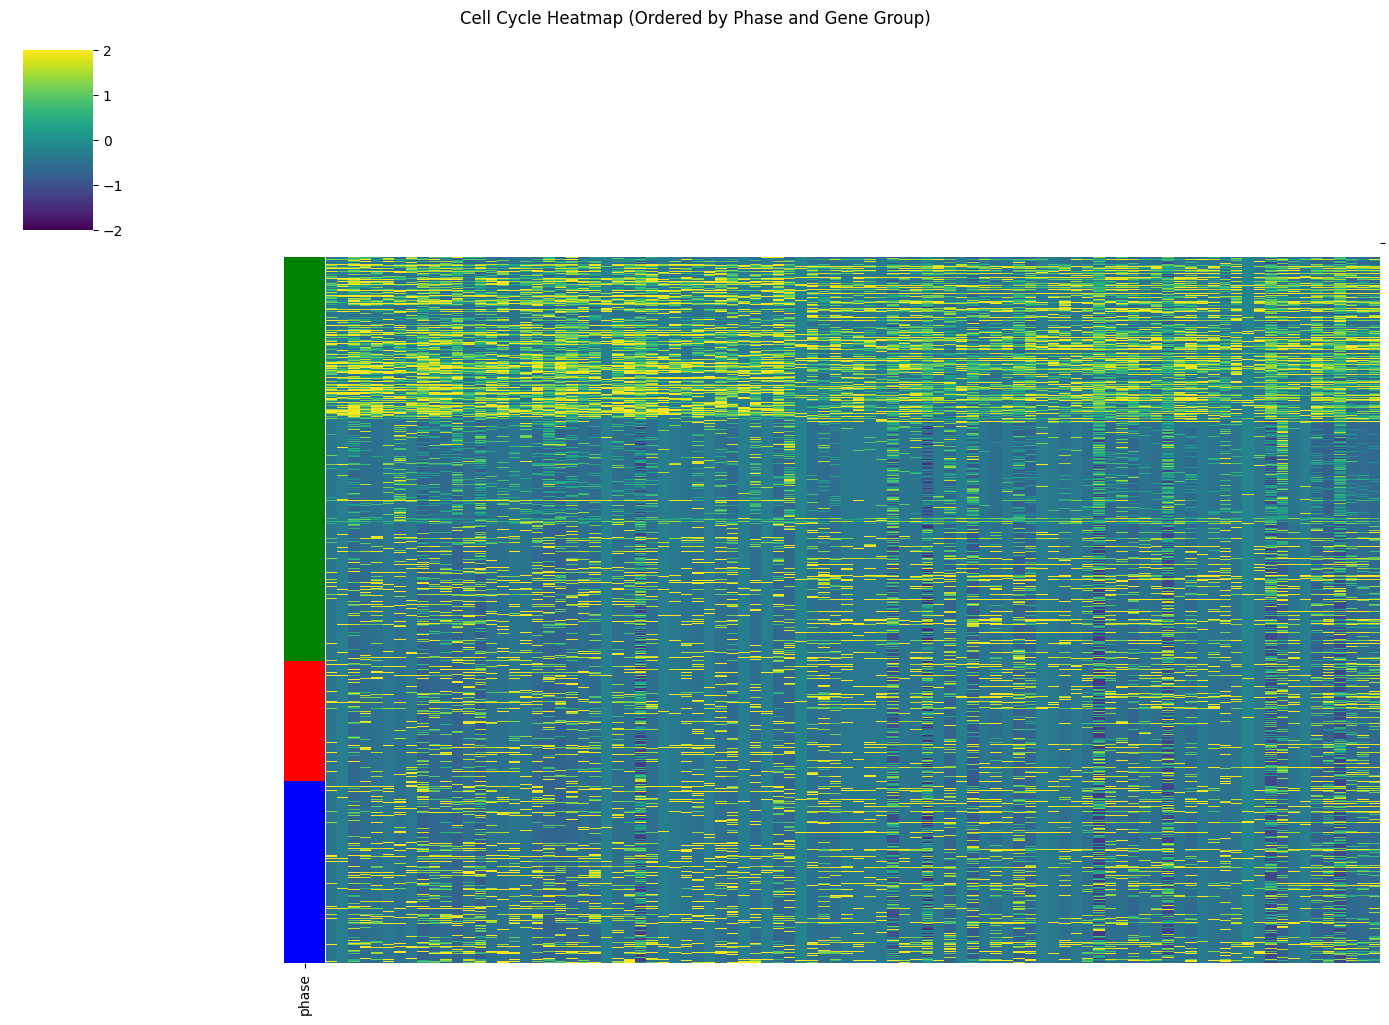

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add phase column for row colors
row_colors = adata_sorted.obs['phase'].map({'G1': 'green', 'S': 'red', 'G2M': 'blue'})

sns.clustermap(
    heatmap_df_z,
    row_cluster=False, col_cluster=False,  # keep manual order
    row_colors=row_colors,  # from previous step (based on cell phase)
    col_colors=gene_colors,  # based on gene group
    cmap="viridis",
    yticklabels=False,
    xticklabels=False,
    figsize=(14, 10),
    vmin=-2, vmax=2
)
plt.suptitle("Cell Cycle Heatmap (Ordered by Phase and Gene Group)", y=1.02)
plt.show()


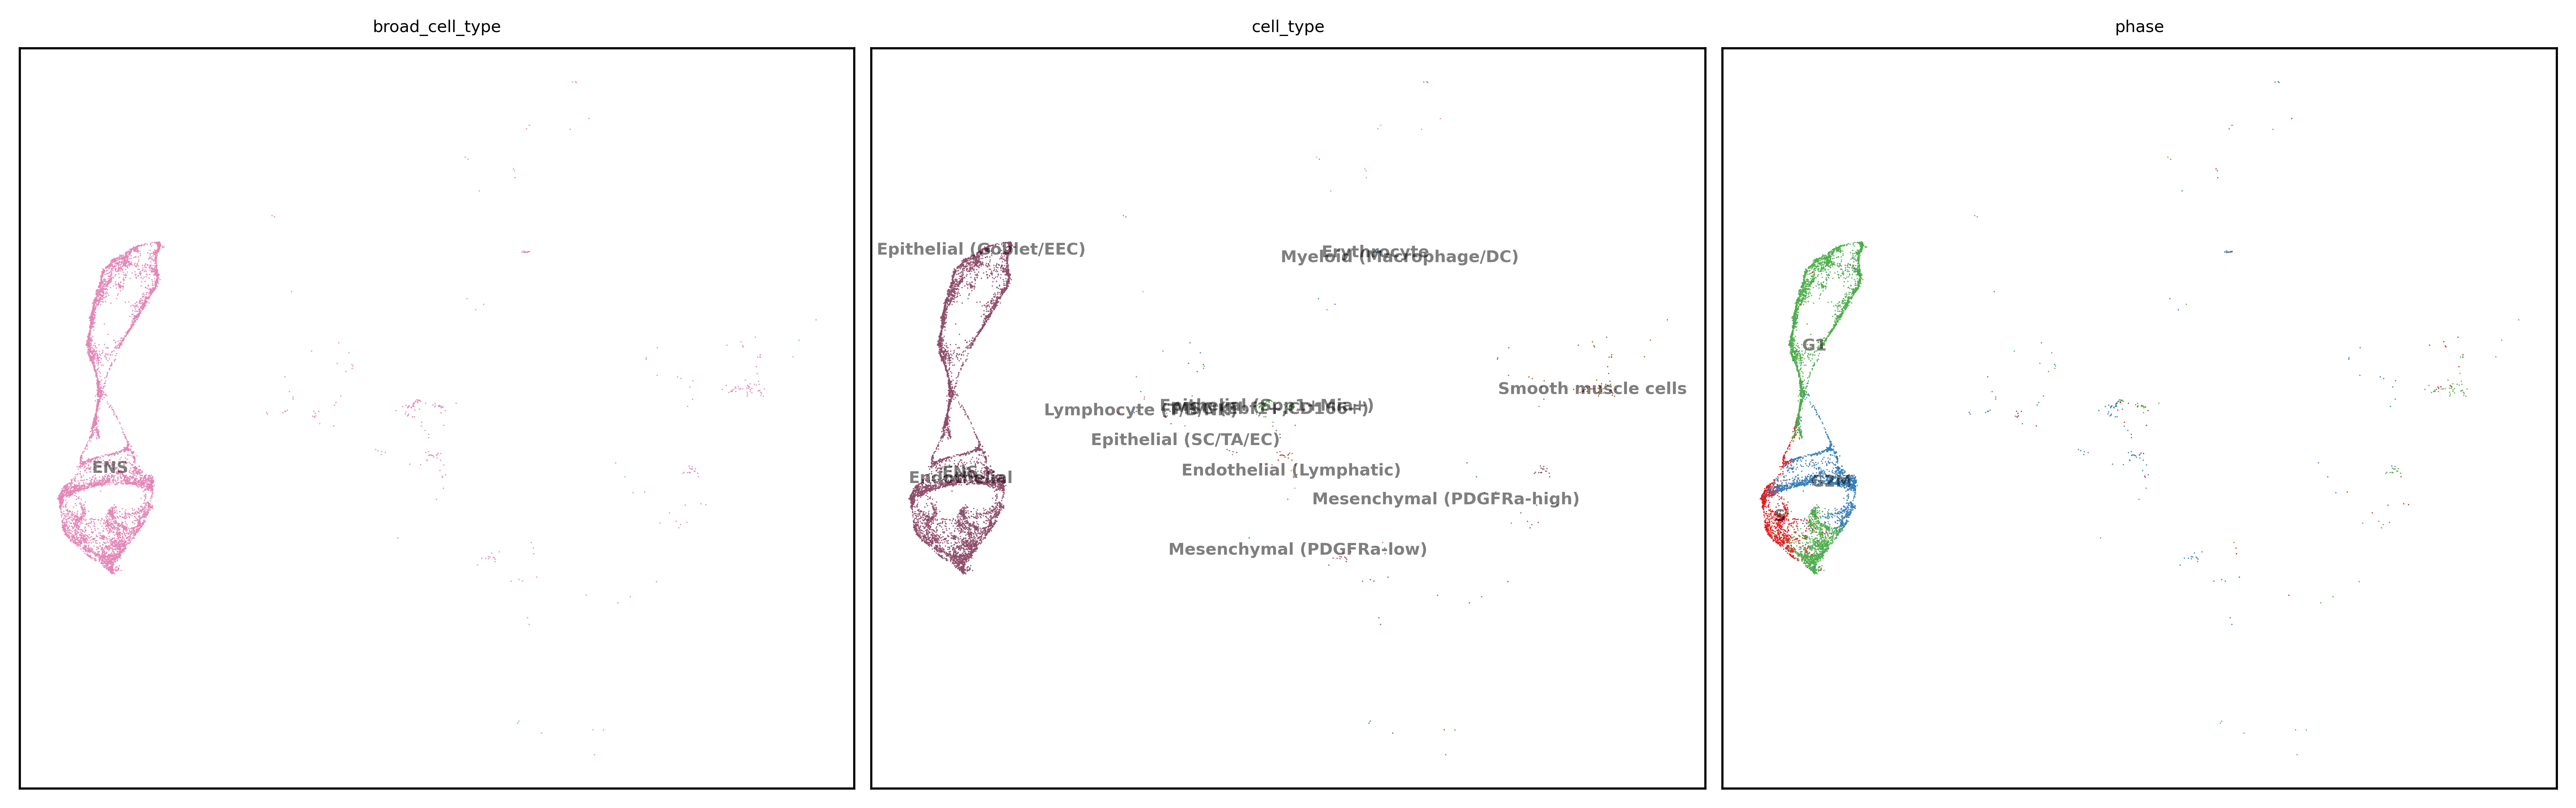

In [43]:
basis = 'concord_hcl'
#basis = 'concord_knn'
show_basis = basis + '_UMAP'
show_cols = ['broad_cell_type', 'cell_type', 'phase']
ccd.pl.plot_embedding(
    adata_ens, show_basis, show_cols, figsize=(13,4), dpi=600, ncols=3, font_size=6, point_size=1, legend_loc="on data",
    pal=pal,
    save_path=None,
)